In [1]:
!pip3 install "gymnasium[box2d]"

In [2]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym
env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False)

In [3]:
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


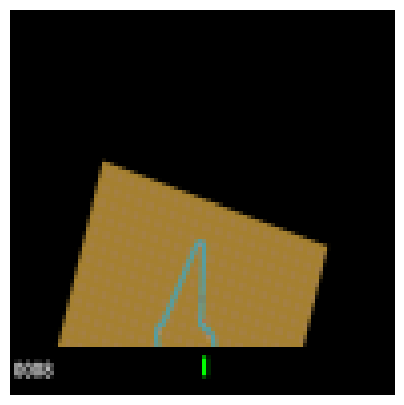

In [4]:
s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

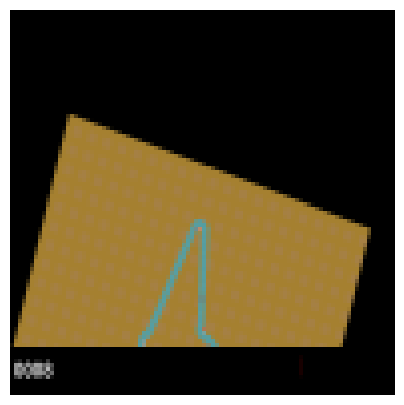

In [5]:
from IPython.display import HTML
import matplotlib.animation as animation

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0) 
    frames.append(s)

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

In [6]:
done = False
observation, info = env.reset()
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

In [7]:
print(reward,terminated,truncated,info)

6.566666666666667 False False {}


In [8]:
class ALSTAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.8,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def next_drive(self, obs: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[tuple(obs.flatten())]))

    def log(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: np.ndarray,
    ):
        obs = self.convert_to_box(obs)
        next_obs = self.convert_to_box(next_obs)

        obs_key = tuple(obs.flatten())
        next_obs_key = tuple(next_obs.flatten())

        future_q_value = (not terminated) * np.max(self.q_values[next_obs_key])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs_key][action]
        )

        self.q_values[obs_key][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    @staticmethod
    def convert_to_box(array: np.ndarray) -> np.ndarray:
        if array.shape != (96, 96, 3):
            raise ValueError(f"Array shape {array.shape} does not match required shape (96, 96, 3)")

        if array.dtype != np.uint8:
            array = array.astype(np.uint8)

        return array

In [9]:
learning_rate = 0.01
n_episodes = 4
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = ALSTAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [10]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.next_drive(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.log(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|█████████████████████████████████████████████| 4/4 [00:54<00:00, 13.73s/it]


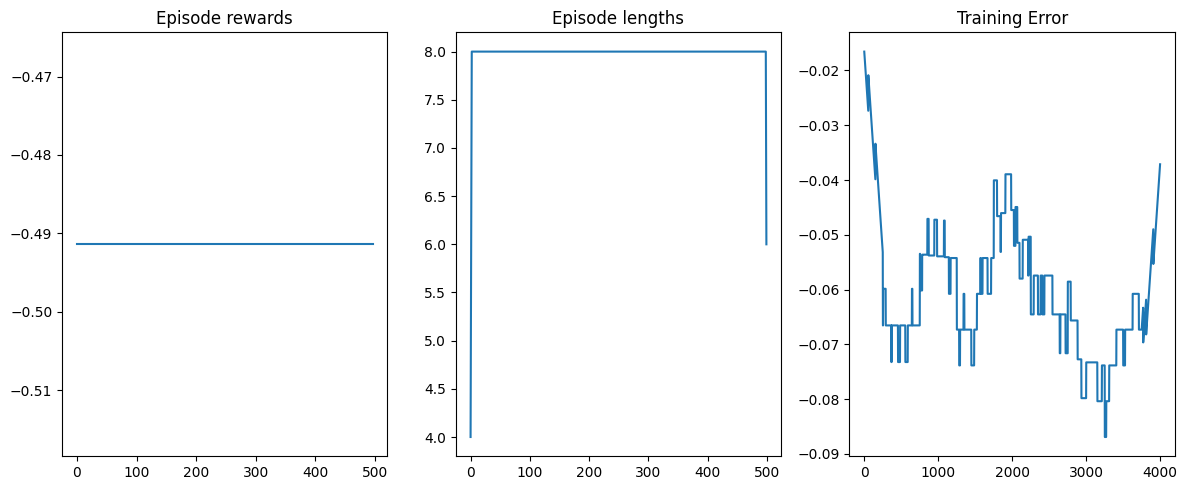

In [11]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

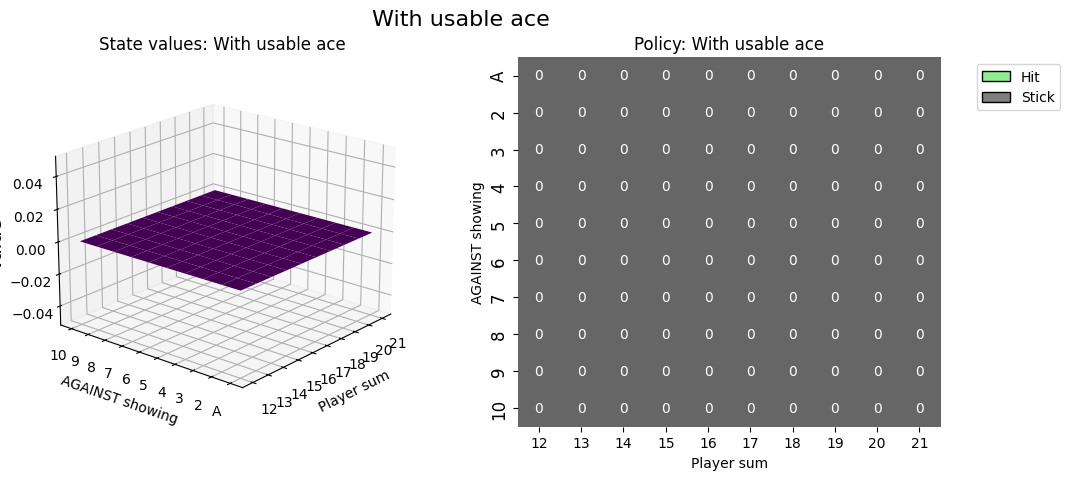

In [12]:
def create_grids(agent, usable_ace=False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        np.arange(12, 22),
        np.arange(1, 11),
    )

    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("AGAINST showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("AGAINST showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

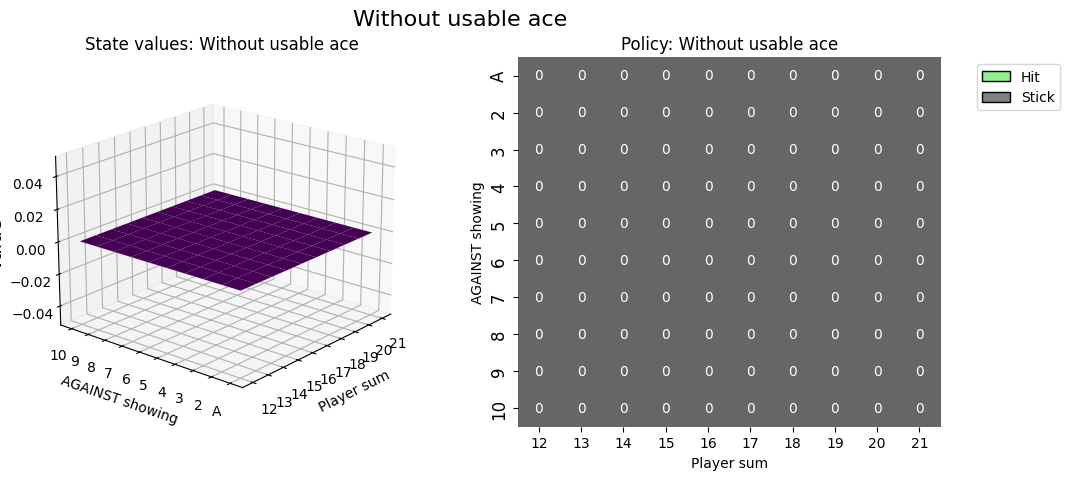

In [13]:
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [14]:
print(reward,terminated,truncated,info)

-0.09999999999999432 False True {'episode': {'r': array([-70.58746], dtype=float32), 'l': array([1000], dtype=int32), 't': array([13.986176], dtype=float32)}}
